github: https://github.com/hccho2/Tacotron-Wavenet-Vocoder-Korean
pdf: https://github.com/hccho2/hccho2.github.io/blob/master/DeepLearning.pdf

In [6]:
import tensorflow as tf

In [7]:
tf.__version__

'2.0.0'

### 1. Mu-law companding

In [2]:
# Input type:
# 1. raw [-1, 1]
# 2. mulaw [-1, 1]
# 3. mulaw-quantize [0, mu]
# If input_type is raw or mulaw, network assumes scalar input and
# discretized mixture of logistic distributions output, otherwise one-hot
# input and softmax output are assumed.
# **NOTE**: if you change the one of the two parameters below, you need to
# re-run preprocessing before training.

# Audio
sample_rate = 24000,  # 

# shift can be specified by either hop_size(우선) or frame_shift_ms
hop_size = 300,             # frame_shift_ms = 12.5ms
fft_size=2048,   # n_fft. 주로 1024로 되어있는데, tacotron에서 2048사용
win_size = 1200,   # 50ms
num_mels=80,

#Spectrogram Pre-Emphasis 
## (Lfilter: Reduce spectrogram noise and helps model certitude levels. 
###         Also allows for better G&L phase reconstruction)
## 스펙트로그램의 노이즈를 낮추고 확실성에 대한 등급을 높인다. 또한, 음파의 G&L을 이용한 재건축에도 좋은 영향을 준다. (stft)
preemphasize = True, #whether to apply filter
preemphasis = 0.97,
min_level_db = -100, #데시벨?
ref_level_db = 20,

#Whether to normalize mel spectrograms to some predefined range (following below parameters)
signal_normalization = True, 
#Only relevant if mel_normalization = True
allow_clipping_in_normalization = True,

#Whether to scale the data to be symmetric around 0. 
## (Also multiplies the output range by 2, faster and cleaner convergence)
# 분포를 0을 중심으로 좌우 대칭이 되도록 만든다.
## 범위를 2로 곱해줘서 수렴 속도를 높인다.
symmetric_mels = True, 

#max absolute value of data. If symmetric, data will be [-max, max] else [0, max] 
## (Must not be too big to avoid gradient explosion, not too small for fast convergence)
# 값의 범위를 지정한다. [-max, max] 사이가 되도록, 그외에는 [0, max] 
## 값이 너무 크면 미분 수렴이 않하거나, 너무 작으면 수렴속도가 너무 작아질수 있다. 
max_abs_value = 4., 


rescaling=True,
rescaling_max=0.999, 

#Whether to clip silence in Audio (at beginning and end of audio only, not the middle)
# 처음과 마지막 부분에 조용한 부분 자를것인가?
trim_silence = True, 
#M-AILABS (and other datasets) trim params 
## (there parameters are usually correct for any data, but definitely must be tuned for specific speakers)
## 아래와 같은 설정이 대부분 데이터에서 다 맞으나 특정 스피커에서는 튜닝을 해줘야 한다??
trim_fft_size = 512, 
trim_hop_size = 128,
trim_top_db = 23,

#OOM에러??
# For cases of OOM (Not really recommended, only use if facing unsolvable OOM errors, 
## also consider clipping your samples to smaller chunks)
clip_mels_length = True,

#Only relevant when clip_mels_length = True, 
##please only use after trying output_per_steps=3 and still getting OOM errors.
max_mel_frames = 1000,  



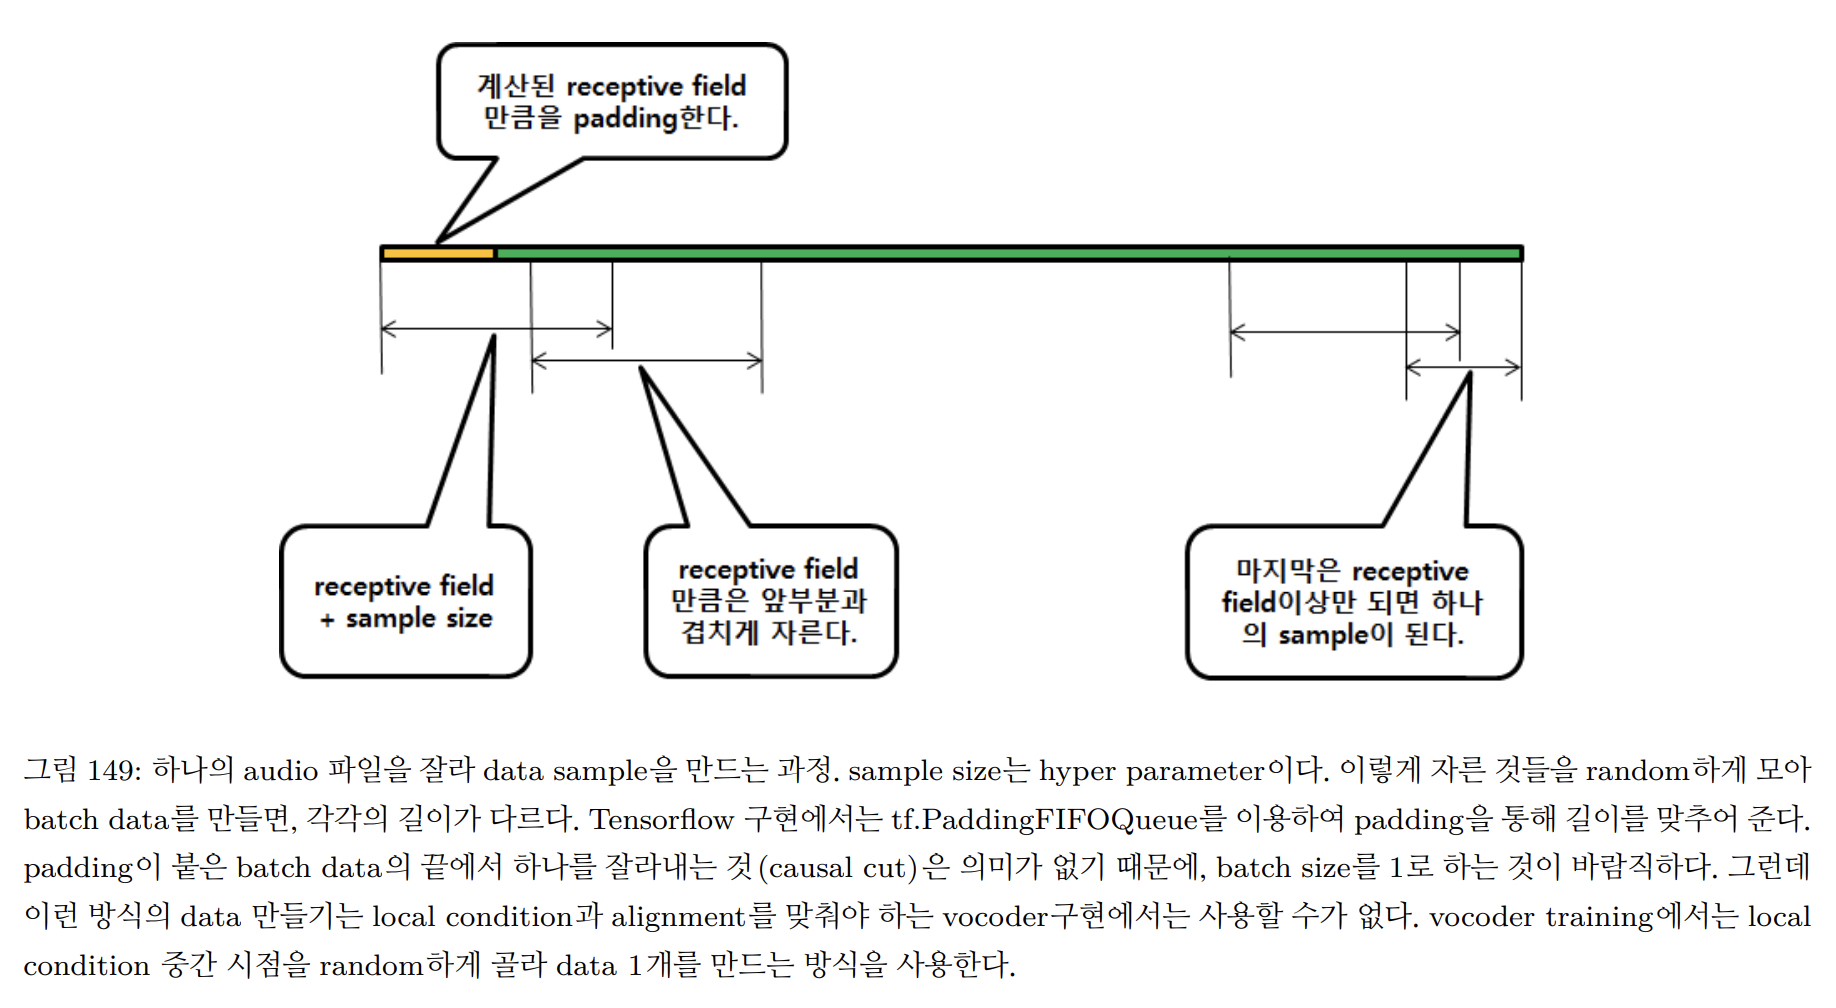

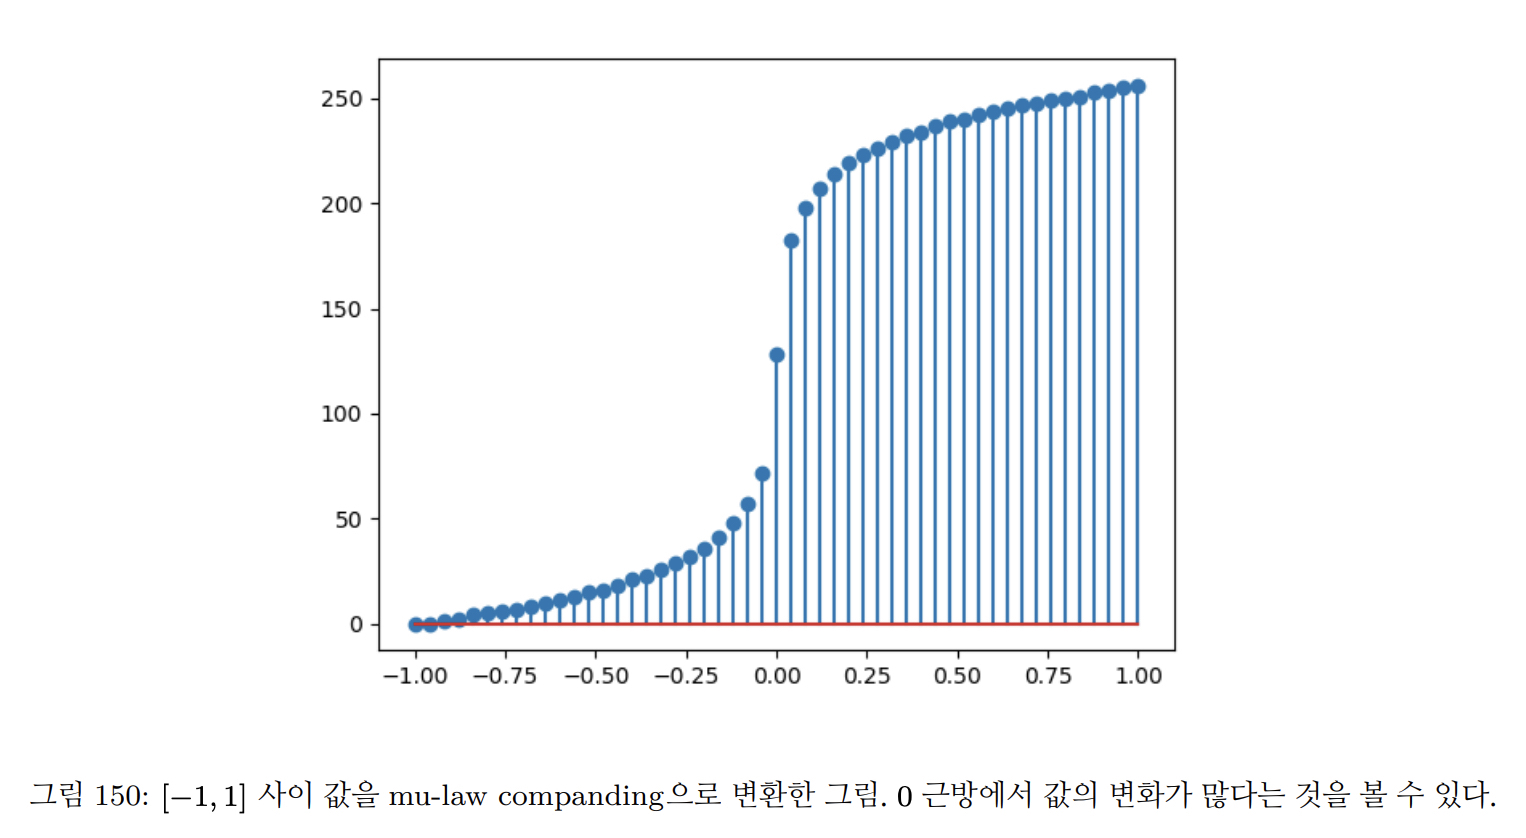

In [ ]:
#audio는 데이터
#quantization_channels = 65,536
def mu_law_encode(audio, quantization_channels):
    '''Quantizes waveform amplitudes.'''
    with tf.name_scope('encode'):
        mu = tf.to_float(quantization_channels - 1)
        # Perform mu-law companding transformation (ITU-T, 1988).
        # Minimum operation is here to deal with rare large amplitudes caused
        # by resampling.
        safe_audio_abs = tf.minimum(tf.abs(audio), 1.0)
        magnitude = tf.log1p(mu * safe_audio_abs) / tf.log1p(mu)  # tf.log1p(x) = log_e(1+x)
        signal = tf.sign(audio) * magnitude
        # Quantize signal to the specified number of levels.
        return tf.to_int32((signal + 1) / 2 * mu + 0.5)


def mu_law_decode(output, quantization_channels, quantization=True):
    '''Recovers waveform from quantized values.'''
    with tf.name_scope('decode'):
        mu = quantization_channels - 1
        # Map values back to [-1, 1].
        if quantization:
            signal = 2 * (tf.to_float(output) / mu) - 1
        else:
            signal = output
        # Perform inverse of mu-law transformation.
        magnitude = (1 / mu) * ((1 + mu)**abs(signal) - 1)
        return tf.sign(signal) * magnitude

In [ ]:
# 전처리 된 데이터 형태
# Tacotron 코드와 맞추기 위해, 같은 key를 사용한다.
data = {
    'audio': out.astype(out_dtype),
    'mel': mel_spectrogram.T,  
    'linear': linear_spectrogram.T,
    'time_steps': time_steps,
    'mel_frames': mel_frames,
    'text': text,
    'tokens': text_to_sequence(text),   # eos(~)에 해당하는 "1"이 끝에 붙는다.
    'loss_coeff': 1  # For Tacotron
}

### 2. Dilation layer

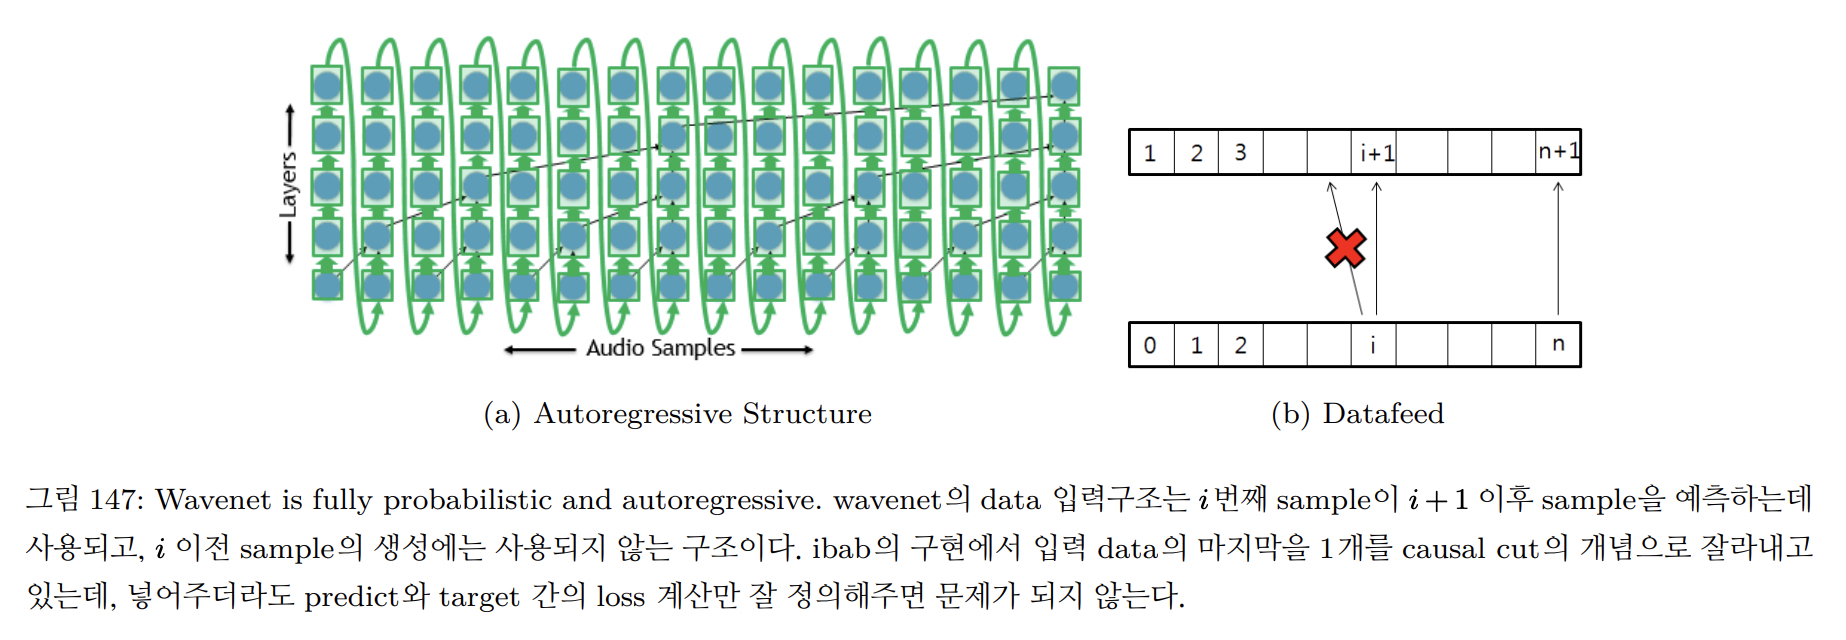

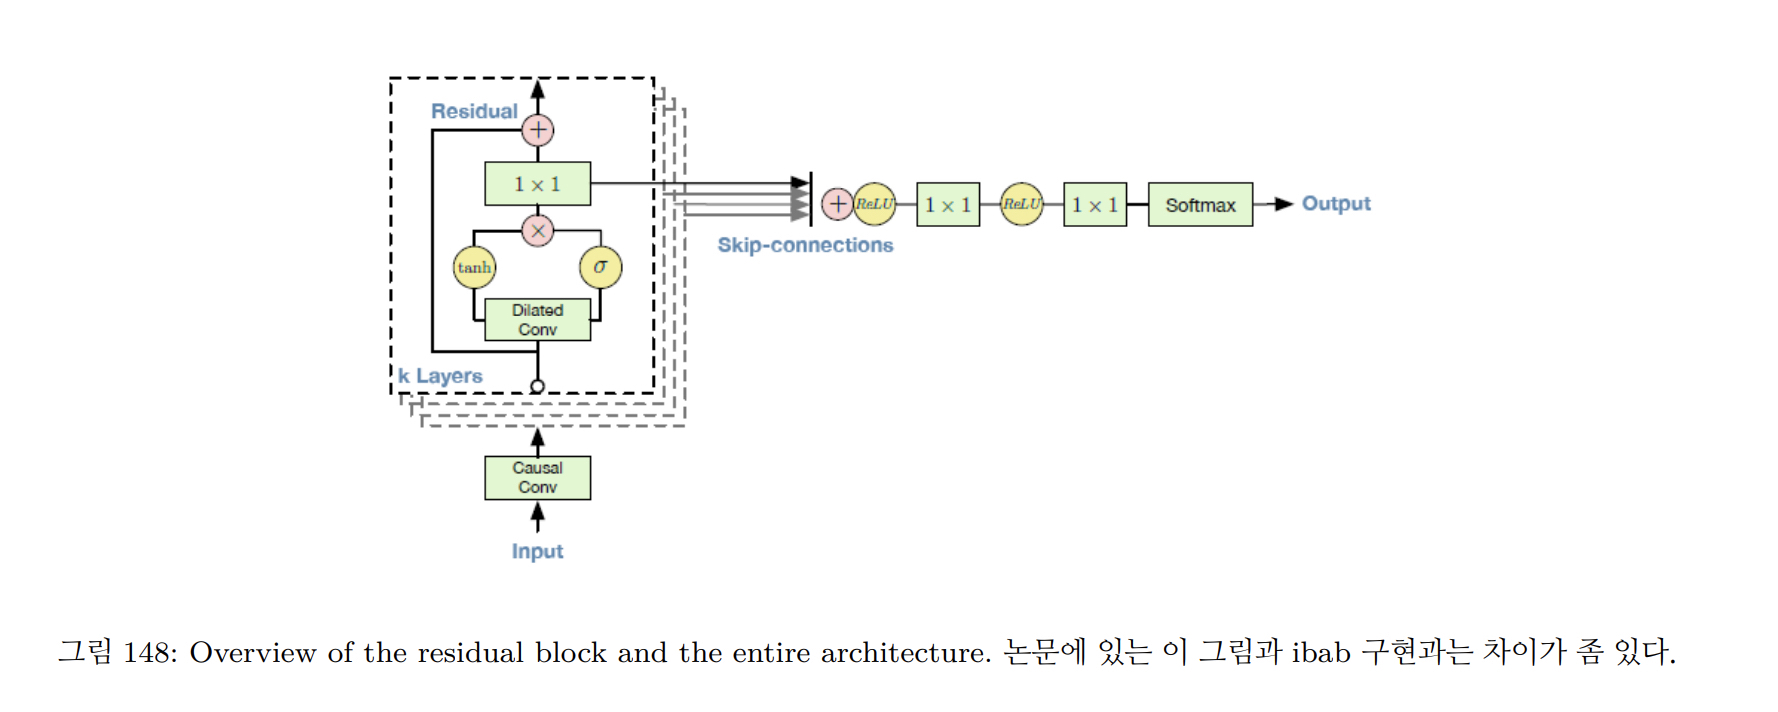

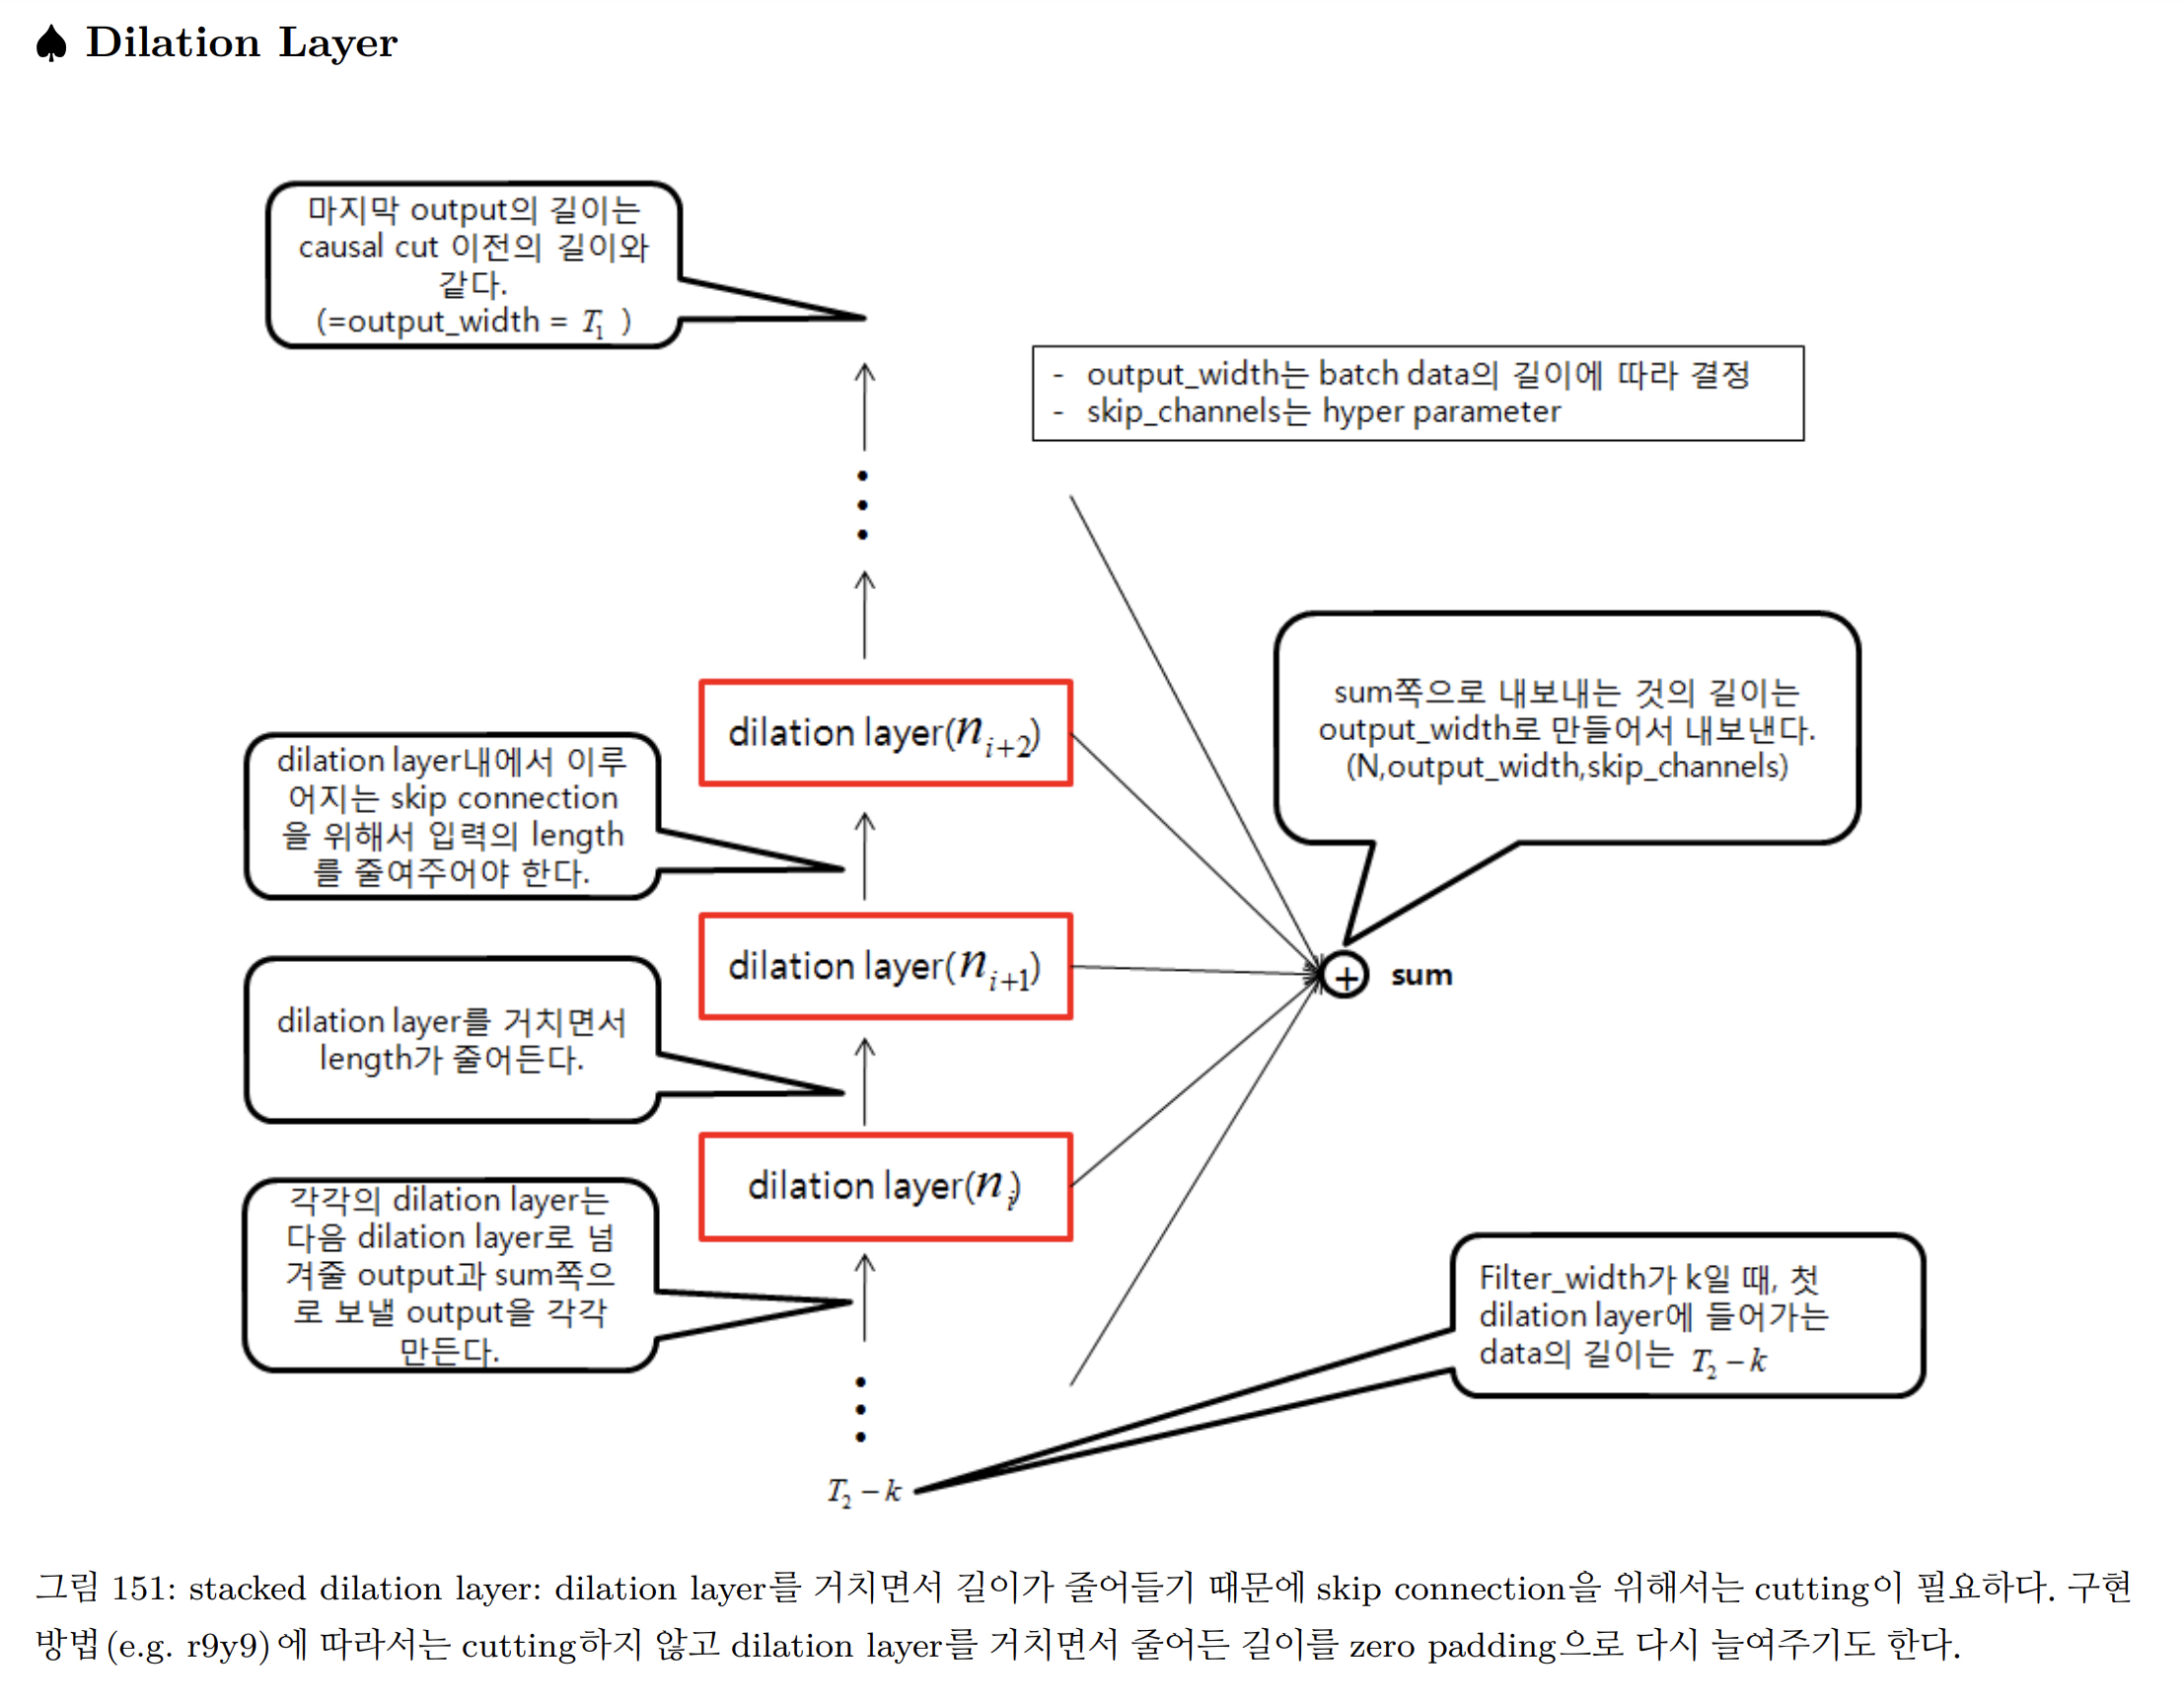

- input_batch: (batch_size,?,1)  <-- 마지막 1은 channel 1을 의미
- dilations = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, ...],
- layer_index: 몇 번째 dilations 레이어 인가?
- local_condition_batch: upsample 크기로 mel spectrogram의 값에 영향을 받는다. data['mel']
- global_condition_batch: tf.FIFOQueue에서 불려진 speaker_id? train_vocoder.py line.95 // datafeeder_wavenet.py line.84
   - (batch_size, 1, self.global_condition_channels)  <--- 가운데 1은 크기 1짜리 data FC대신에 conv1d를 적용하기 위해 강제로 넣었다고 봐야 한다.
- output_width:  The 1x1 conv to produce the skip output  
    - tf.shape(out)[1] <--- 이 값은 dilation에 따라 점점 작아진다. [105114 -> 105112 -> ...  -> 100512 -> 100000(output_width)]
    - 아래의 output_width는 최대 SAMPLE_SIZE = 100,000까지 이고, 짧은 파일이나 파일의 끝부분이면 더 100,000 안 될 수 있다.
    - 모든 dilated convolution을 통과 한 이후 길이. +1을 하는 이유는 causal cut으로 줄어든 1만큼 다시 더해준다.  
    ```if self.train_mode==True:
        output_width = tf.shape(input_batch)[1] - self.receptive_field + 1```

In [ ]:
    l2_regularization_strength = 0,  # Coefficient in the L2 regularization.
    sample_size = 15000,              # Concatenate and cut audio samples to this many samples
    silence_threshold = 0,             # Volume threshold below which to trim the start and the end from the training set samples. e.g. 2

    
    filter_width = 2,
    gc_channels = 32,                  # global_condition_vector의 차원. 이것 지정함으로써, global conditioning을 모델에 반영하라는 의미가 된다.
    
    input_type="raw",    # 'mulaw-quantize', 'mulaw', 'raw',   mulaw, raw 2가지는 scalar input
    scalar_input = True,   # input_type과 맞아야 함.
    
    
    dilations = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512,
                  1, 2, 4, 8, 16, 32, 64, 128, 256, 512,
                  1, 2, 4, 8, 16, 32, 64, 128, 256, 512,
                  1, 2, 4, 8, 16, 32, 64, 128, 256, 512,
                  1, 2, 4, 8, 16, 32, 64, 128, 256, 512],
    residual_channels = 32,
    dilation_channels = 32,
    quantization_channels = 256,
    out_channels = 30,  # discretized_mix_logistic_loss를 적용하기 때문에, 3의 배수
    skip_channels = 512,
    use_biases = True,
    
    initial_filter_width = 32,
    upsample_factor=[5, 5, 12],   # np.prod(upsample_factor) must equal to hop_size



    # wavenet training hp
    wavenet_batch_size = 8,            # 16--> OOM. wavenet은 batch_size가 고정되어야 한다.
    store_metadata = False,
    num_steps = 200000,                # Number of training steps

    #Learning rate schedule
    wavenet_learning_rate = 1e-3, #wavenet initial learning rate
    wavenet_decay_rate = 0.5, #Only used with 'exponential' scheme. Defines the decay rate.
    wavenet_decay_steps = 300000, #Only used with 'exponential' scheme. Defines the decay steps.

    #Regularization parameters
    wavenet_clip_gradients = False, #Whether the clip the gradients during wavenet training.


    
    optimizer = 'adam',
    momentum = 0.9,                   # 'Specify the momentum to be used by sgd or rmsprop optimizer. Ignored by the adam optimizer.
    max_checkpoints = 3,             # 'Maximum amount of checkpoints that will be kept alive. Default: '    


In [ ]:
def _create_dilation_layer(self, input_batch, layer_index, dilation,local_condition_batch
                            ,global_condition_batch, output_width):
    with tf.variable_scope('dilation_layer'):
        #data: input_batch
        # kernel : filter_width
        # dilation_rate: 커널 사이의 간격
        
        #tf.tanh(conv_filter)
        conv_filter = tf.layers.conv1d(input_batch,filters=self.dilation_channels
                                       ,kernel_size=self.filter_width,dilation_rate=dilation
                                       ,padding='valid',use_bias=self.use_biases,name='conv_filter')
        
        #tf.sigmoid(conv_gate)
        conv_gate = tf.layers.conv1d(input_batch,filters=self.dilation_channels
                                     ,kernel_size=self.filter_width,dilation_rate=dilation
                                     ,padding='valid',use_bias=self.use_biases,name='conv_gate')    

        if global_condition_batch is not None:
            conv_filter += tf.layers.conv1d(global_condition_batch,filters=self.dilation_channels
                                            ,kernel_size=1,padding="same",use_bias=False,name="gc_filter")
            conv_gate += tf.layers.conv1d(global_condition_batch,filters=self.dilation_channels
                                          ,kernel_size=1,padding="same",use_bias=False,name="gc_gate")

        if local_condition_batch is not None:
            local_filter = tf.layers.conv1d(local_condition_batch,filters=self.dilation_channels
                                            ,kernel_size=1,padding="same",use_bias=False,name="lc_filter")
            local_gate = tf.layers.conv1d(local_condition_batch,filters=self.dilation_channels
                                          ,kernel_size=1,padding="same",use_bias=False,name="lc_gate")

            local_filter = tf.slice(local_filter, [0, 0, 0], [-1, tf.shape(conv_filter)[1], -1])
            local_gate = tf.slice(local_gate, [0, 0, 0], [-1, tf.shape(conv_gate)[1], -1])

            conv_filter += local_filter
            conv_gate += local_gate            


        out = tf.tanh(conv_filter) * tf.sigmoid(conv_gate)

        # The 1x1 conv to produce the residual output  == FC
        ## it's to next dilation layer output(residual channel)
        transformed = tf.layers.conv1d(out,filters=self.residual_channels,kernel_size=1,padding="same"
                                       ,use_bias=self.use_biases,name="dense")

        # The 1x1 conv to produce the skip output
        # tf.shape(out)[1] <--- 이 값은 dilation에 따라 점점 작아진다. [105114 -> 105112 -> ...
        #     -> 100512 -> 100000(output_width)]

        # skip channel(summation output)
        skip_cut = tf.shape(out)[1] - output_width
        out_skip = tf.slice(out, [0, skip_cut, 0], [-1, -1, self.dilation_channels])
        skip_contribution = tf.layers.conv1d(out_skip,filters=self.skip_channels,kernel_size=1
                                             ,padding="same",use_bias=self.use_biases,name="skip")

        input_cut = tf.shape(input_batch)[1] - tf.shape(transformed)[1]
        input_batch = tf.slice(input_batch, [0, input_cut, 0], [-1, -1, -1])
        
        # skip_contribution: 결과값으로 쌓임. input_batch + transformed: 다음 단계의 입력으로 들어감
        return skip_contribution, input_batch + transformed   

### 3. 네트워크 만들기

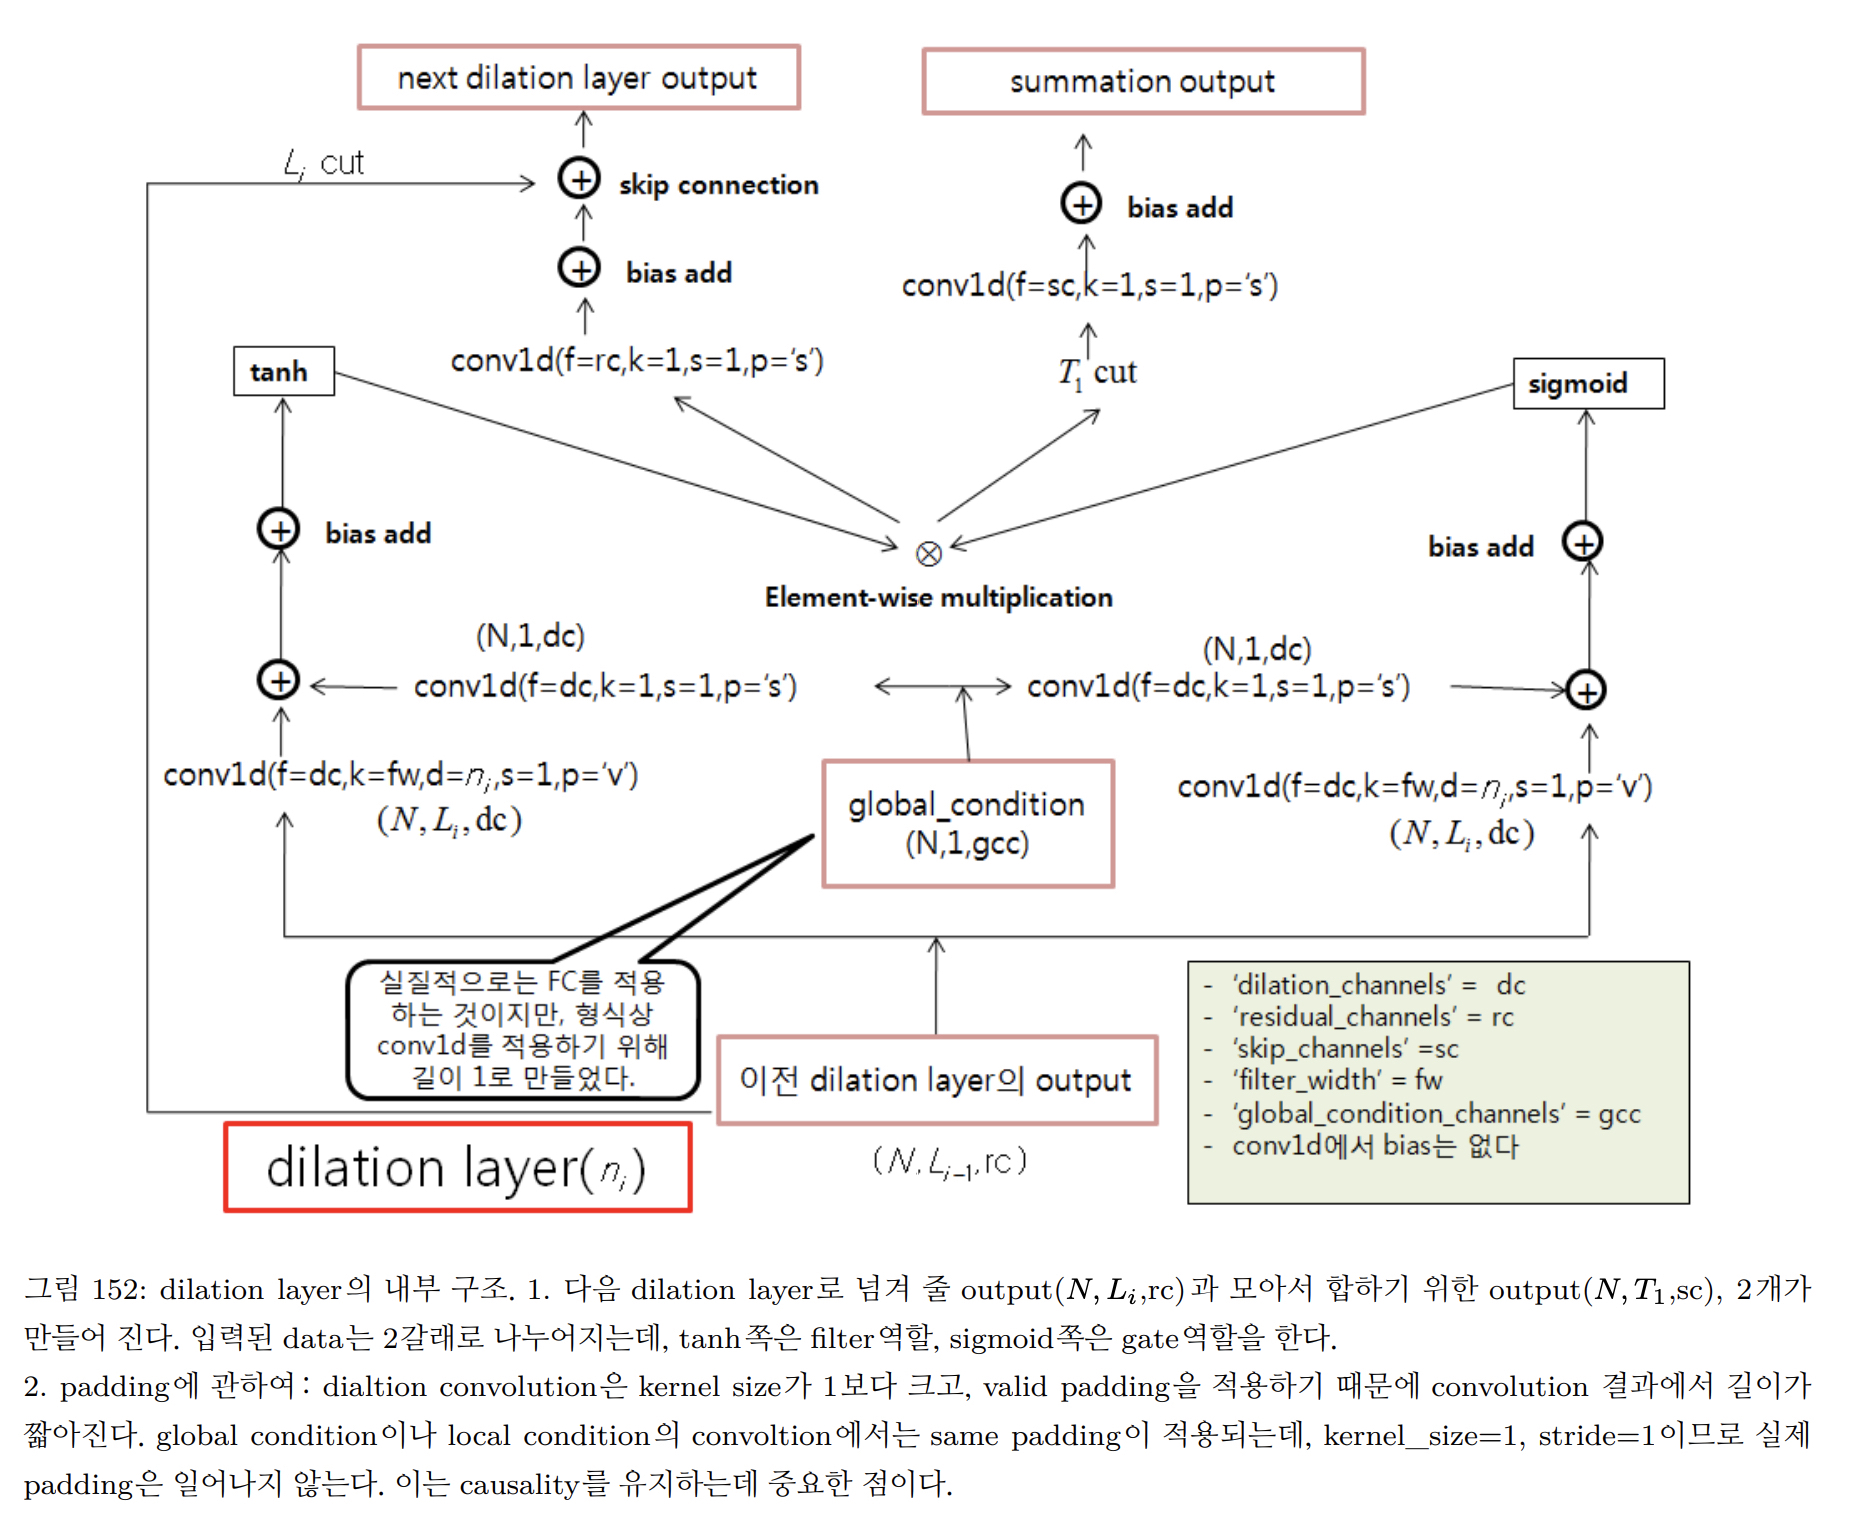

In [ ]:
def _create_network(self, input_batch,local_condition_batch, global_condition_batch):  
    '''Construct the WaveNet network.'''
    # global_condition_batch: (batch_size, 1, self.global_condition_channels)  
    ##   <--- 가운데 1은 크기 1짜리 data FC대신에 conv1d를 적용하기 위해 강제로 넣었다고 봐야 한다.

    if self.train_mode==False:
        self._create_queue()

    outputs = []
    current_layer = input_batch  # causal cut으로 길이 1이 줄어든 상태
    if self.train_mode==False:
        self.causal_queue = tf.scatter_update(self.causal_queue,tf.range(self.batch_size)
                                              ,tf.concat([self.causal_queue[:,1:,:],input_batch],axis=1) )
        current_layer = self.causal_queue

        self.local_condition_queue  = tf.scatter_update(self.local_condition_queue,tf.range(self.batch_size)
                                                        ,tf.concat([self.local_condition_queue[:,1:,:]
                                                                    ,local_condition_batch],axis=1) )
        local_condition_batch = self.local_condition_queue



    # Pre-process the input with a regular convolution
    # conv1d를 통과 하면서, (filter_width-1)= 1 만큼 더 줄어 있다.
    current_layer = self._create_causal_layer(current_layer)  

    # 아래의 output_width는 최대 SAMPLE_SIZE = 100,000까지 이고, 짧은 파일이나 파일의 끝부분이면 더 100,000 안 될 수 있다.
    if self.train_mode==True:
        # 모든 dilated convolution을 통과 한 이후 길이. +1을 하는 이유는 causal cut으로 줄어든 1만큼 다시 더해준다.
        output_width = tf.shape(input_batch)[1] - self.receptive_field + 1  
    else:
        output_width = 1

    # Add all defined dilation layers.
    with tf.variable_scope('dilated_stack'):
        for layer_index, dilation in enumerate(self.dilations): 
            # [1, 2, 4, 8, 16, 32, 64, 128, 256, 512
            #, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512
            #, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512
            #, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512
            #, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
            with tf.variable_scope('layer{}'.format(layer_index)):

                if self.train_mode==False:
                    self.dilation_queue[layer_index] = \
                        tf.scatter_update(self.dilation_queue[layer_index]
                                          ,tf.range(self.batch_size)
                                          ,tf.concat([self.dilation_queue[layer_index][:,1:,:],current_layer],axis=1))
                    current_layer =  self.dilation_queue[layer_index]

                output, current_layer = \
                    self._create_dilation_layer(current_layer, layer_index, dilation,local_condition_batch
                                                ,global_condition_batch, output_width)
                outputs.append(output)
    with tf.name_scope('postprocessing'):
        # Perform (+) -> ReLU -> 1x1 conv -> ReLU -> 1x1 conv to
        # postprocess the output.


        # We skip connections from the outputs of each layer, adding them
        # all up here.
        total = sum(outputs)   # list를 sum하는 것이므로, sum 후, (N,output_width,'skip_channels')
        transformed1 = tf.nn.relu(total)
        conv1 = tf.layers.conv1d(transformed1,filters=self.skip_channels,kernel_size=1
                                 ,padding="same",use_bias=self.use_biases)

        transformed2 = tf.nn.relu(conv1)
        if self.scalar_input:
            conv2 = tf.layers.conv1d(transformed2,filters=self.out_channels,kernel_size=1
                                     ,padding="same",use_bias=self.use_biases)
        else:
            conv2 = tf.layers.conv1d(transformed2,filters=self.quantization_channels,kernel_size=1
                                     ,padding="same",use_bias=self.use_biases)

    return conv2

### 4. loss 값 구하기

- input_batch: (batch_size,?,1)

In [ ]:
#local_condition: 
def create_upsample(self, local_condition_batch):
    local_condition_batch = tf.expand_dims(local_condition_batch, [3])
    # local condition batch N H W C

    for i in range(len(self.upsample_factor)):
        local_condition_batch = tf.layers.conv2d_transpose(local_condition_batch,filters=1, kernel_size=(self.upsample_factor[i], self.filter_width),
                                               strides=(self.upsample_factor[i],1),padding='same',use_bias=False,name='upsample{}'.format(i))

    local_condition_batch = tf.squeeze(local_condition_batch, [3])
    return local_condition_batch

- global_condition_batch: tf.FIFOQueue에서 불려진 speaker_id? train_vocoder.py line.95 // datafeeder_wavenet.py line.84
   - (batch_size, 1, self.global_condition_channels)  <--- 가운데 1은 크기 1짜리 data FC대신에 conv1d를 적용하기 위해 강제로 넣었다고 봐야 한다.
- l2_regularization_strength:  기본값은 0# Coefficient in the L2 regularization.

In [ ]:
def add_loss(self, input_batch,local_condition=None, global_condition_batch=None
             , l2_regularization_strength=None, name='wavenet'):
    '''Creates a WaveNet network and returns the autoencoding loss.
    The variables are all scoped to the given name.
    '''
    with tf.variable_scope(name):
        # We mu-law encode and quantize the input audioform.
        # quantization_channels 크기의 one hot encoding을 적용한 예정. 16bit= 65536개였다면
        ##,  quantization_channels로 줄이는 효과가 있다.
        # mu law encoding은 bit를 단순히 줄이는 것보다 advanced된 방식으로 줄인다.
        # input_batch: (batch_size,?,1)  <-- 마지막 1은 channel 1을 의미
        
        # "quantization_channels": 256   ---> (batch_size, ?, 1)
        encoded_input = mu_law_encode(input_batch, self.quantization_channels)  
        
         # (self.batch_size, 1, self.global_condition_channels) <--- 가운데 1은 강제로 reshape
        gc_embedding = self._embed_gc(global_condition_batch)
        
         #  (1, ?, quantization_channels=256)
        encoded = self._one_hot(encoded_input)     
        if self.scalar_input:
            network_input = tf.reshape( tf.cast(input_batch, tf.float32), [self.batch_size, -1, 1])
        else:
            network_input = encoded

        # Cut off the last sample of network input to preserve causality.
        network_input_width = tf.shape(network_input)[1] - 1
        if self.scalar_input:
            input = tf.slice(network_input, [0, 0, 0], [-1, network_input_width,1])
        else:
            input = tf.slice(network_input, [0, 0, 0], [-1, network_input_width, self.quantization_channels])


        # local condition
        if local_condition is not None:
            local_condition = self.create_upsample(local_condition) # 함수

        # (batch_size, ?, quantization_channels=256) , (batch_size, 1, self.global_condition_channels)
        raw_output = self._create_network(input,local_condition, gc_embedding)#함수


        with tf.name_scope('loss'):
            # Cut off the samples corresponding to the receptive field
            # for the first predicted sample.

            # scalar input인 경우에도 target은 mu-law companding된 것이 된다.
            # [-1,-1,-1] --> 나머지 모두
            target_output = tf.slice(network_input , [0, self.receptive_field, 0],[-1, -1, -1])   

            # 이 부분이 중요
            if self.scalar_input:
                loss = discretized_mix_logistic_loss(raw_output, target_output,num_class=2**16, reduce=False)
                reduced_loss = tf.reduce_mean(loss)                    
            else:
                # 3 dim array의 loss를 계산학 위해, 2 dim으로 변환한다. batch와 time 부분을 합쳐서 2dim으로 변환
                target_output = tf.reshape(target_output, [-1, self.quantization_channels])
                prediction = tf.reshape(raw_output, [-1, self.quantization_channels])
                loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=target_output)
                reduced_loss = tf.reduce_mean(loss)

            tf.summary.scalar('loss', reduced_loss)

            if l2_regularization_strength is None:
                self.loss = reduced_loss
            else:
                # L2 regularization for all trainable parameters
                l2_loss = tf.add_n([tf.nn.l2_loss(v)  for v in tf.trainable_variables() if not('bias' in v.name)])

                # Add the regularization term to the loss
                total_loss = (reduced_loss + l2_regularization_strength * l2_loss)

                tf.summary.scalar('l2_loss', l2_loss)
                tf.summary.scalar('total_loss', total_loss)

                self.loss = total_loss

### 5. 최적화

wavenet_learning_rate = 1e-3, #wavenet initial learning rate
global_step: decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
wavenet_decay_steps = 300000, #Only used with 'exponential' scheme. Defines the decay steps.
wavenet_decay_rate =  0.5, #Only used with 'exponential' scheme. Defines the decay rate.
optimizer.compute_gradients()
wavenet_clip_gradients = False #Whether the clip the gradients during wavenet training.
clip_by_global_norm : https://www.tensorflow.org/api_docs/python/tf/clip_by_global_norm
clipped_gradients

exponential_decay: https://www.tensorflow.org/api_docs/python/tf/compat/v1/train/exponential_decay

In [ ]:
tf.clip_by_global_norm(
    t_list = [1,2,3,4,5],
    clip_norm = 1,
    use_norm=None,
    name=None
)
t_list[i] * clip_norm / max(global_norm, clip_norm)
global_norm = sqrt(sum([l2norm(t)**2 for t in t_list]))
#If clip_norm > global_norm: 그래로 사용하거나, otherwise they're all shrunk by the global ratio.
#If global_norm == infinit: set NaN
#if global_norm None : ignore

In [ ]:
def add_optimizer(self, hparams,global_step):
    '''Adds optimizer to the graph. Supposes that initialize function has already been called.
    '''
    with tf.variable_scope('optimizer'):
        hp = hparams

        learning_rate = tf.train.exponential_decay(hp.wavenet_learning_rate, global_step
                                                   ,hp.wavenet_decay_steps,hp.wavenet_decay_rate)

        #Adam optimization
        self.learning_rate = learning_rate
        optimizer = tf.train.AdamOptimizer(learning_rate)
        
        # len(tf.trainable_variables()) = len(variables)
        gradients, variables = zip(*optimizer.compute_gradients(self.loss))   
        self.gradients = gradients

        #Gradients clipping
        if hp.wavenet_clip_gradients:
            clipped_gradients, _ = tf.clip_by_global_norm(gradients, 1.)
        else:
            clipped_gradients = gradients

        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            adam_optimize = optimizer.apply_gradients(zip(clipped_gradients, variables),global_step=global_step)        

    #Add exponential moving average
    #https://www.tensorflow.org/api_docs/python/tf/train/ExponentialMovingAverage
    #Use adam optimization process as a dependency
    with tf.control_dependencies([adam_optimize]):
        #Create the shadow variables and add ops to maintain moving averages
        #Also updates moving averages after each update step
        #This is the optimize call instead of traditional adam_optimize one.
        assert tuple(tf.trainable_variables()) == variables #Verify all trainable variables are being averaged
        self.optimize = self.ema.apply(variables) 

In [ ]:
import numpy as np
import tensorflow as tf

from .ops import mu_law_encode,optimizer_factory
from .mixture import discretized_mix_logistic_loss, sample_from_discretized_mix_logistic

class WaveNetModel(object):
    def __init__(self,batch_size,dilations,filter_width,residual_channels,dilation_channels,skip_channels
                 ,quantization_channels=2**8,out_channels=30,
                 use_biases=False,scalar_input=False,initial_filter_width=32,global_condition_channels=None,
                 global_condition_cardinality=None,local_condition_channels=80,upsample_factor=None,train_mode=True):

        self.batch_size = batch_size #배치크기
        self.dilations = dilations#dilations 크기(2의 n승)
        self.filter_width = filter_width
        self.residual_channels = residual_channels
        self.dilation_channels = dilation_channels
        self.quantization_channels = quantization_channels
        self.use_biases = use_biases
        self.skip_channels = skip_channels
        self.scalar_input = scalar_input
        self.initial_filter_width = initial_filter_width
        self.global_condition_channels = global_condition_channels
        self.global_condition_cardinality = global_condition_cardinality
        self.local_condition_channels=local_condition_channels
        self.upsample_factor=upsample_factor
        self.train_mode = train_mode
        self.receptive_field = WaveNetModel.calculate_receptive_field(self.filter_width, self.dilations, self.scalar_input,self.initial_filter_width)
        self.out_channels = out_channels

        self.ema = tf.train.ExponentialMovingAverage(decay=0.9999)
    @staticmethod
    def calculate_receptive_field(filter_width, dilations, scalar_input, initial_filter_width):
        # causal 때문에 length (T-1) + (여기서 계산되는 receptive_field만큼의  padding)  --> 최종 output의 길이가 T가 된다.
        receptive_field = (filter_width - 1) * sum(dilations) + 1  # 마지막 +1은 causal condition 때문에 1개 자른 것의 때문에 길이가 T-1인 되기 때문에 +1을 통해서 입력과 같은 길이 T가 된다.
        if scalar_input:
            receptive_field += initial_filter_width - 1
        else:
            receptive_field += filter_width - 1  # dilation layer에 들어가지 전에 Causal Convolution을 한번 하기 때문에, dilation size = 1짜리가 하나 더 있는 것과 같은 효과
        return receptive_field

    def _create_causal_layer(self, input_batch):
        with tf.name_scope('causal_layer'):
            if self.scalar_input:
                return tf.layers.conv1d(input_batch,filters=self.residual_channels,kernel_size=self.initial_filter_width,padding='valid',dilation_rate=1,use_bias=False)
            else:
                return tf.layers.conv1d(input_batch,filters=self.residual_channels,kernel_size=self.filter_width,padding='valid',dilation_rate=1,use_bias=False)


    def _create_queue(self):
        with tf.variable_scope('queue'):
            if self.scalar_input:
                self.causal_queue = tf.Variable(initial_value=tf.zeros(shape=[self.batch_size,self.initial_filter_width,1], dtype=tf.float32), name='causal_queue', trainable=False)
            else:
                self.causal_queue = tf.Variable(initial_value=tf.zeros(shape=[self.batch_size,self.filter_width,self.quantization_channels], dtype=tf.float32), name='causal_queue', trainable=False)
            
            self.local_condition_queue = tf.Variable(initial_value=tf.zeros(shape=[self.batch_size,self.filter_width,self.local_condition_channels], dtype=tf.float32), name='local_condition_queue', trainable=False)
            
            self.dilation_queue=[]
            for i,d in enumerate(self.dilations):
                q = tf.Variable(initial_value=tf.zeros(shape=[self.batch_size,d*(self.filter_width-1)+1,self.residual_channels], dtype=tf.float32), name='dilation_queue'.format(i), trainable=False)
                self.dilation_queue.append(q)
        
        # restore했을 때, Dilation_Queue,Causal_Queue는 0으로 initialization해야 한다.
        self.queue_initializer= tf.variables_initializer(self.dilation_queue + [self.causal_queue, self.local_condition_queue])

    def _create_dilation_layer(self, input_batch, layer_index, dilation,local_condition_batch,global_condition_batch, output_width):
        with tf.variable_scope('dilation_layer'):
            conv_filter = tf.layers.conv1d(input_batch,filters=self.dilation_channels,kernel_size=self.filter_width,dilation_rate=dilation,padding='valid',use_bias=self.use_biases,name='conv_filter')
            conv_gate = tf.layers.conv1d(input_batch,filters=self.dilation_channels,kernel_size=self.filter_width,dilation_rate=dilation,padding='valid',use_bias=self.use_biases,name='conv_gate')    
            
            if global_condition_batch is not None:
                conv_filter += tf.layers.conv1d(global_condition_batch,filters=self.dilation_channels,kernel_size=1,padding="same",use_bias=False,name="gc_filter")
                conv_gate += tf.layers.conv1d(global_condition_batch,filters=self.dilation_channels,kernel_size=1,padding="same",use_bias=False,name="gc_gate")
    
            if local_condition_batch is not None:
                local_filter = tf.layers.conv1d(local_condition_batch,filters=self.dilation_channels,kernel_size=1,padding="same",use_bias=False,name="lc_filter")
                local_gate = tf.layers.conv1d(local_condition_batch,filters=self.dilation_channels,kernel_size=1,padding="same",use_bias=False,name="lc_gate")
                
                local_filter = tf.slice(local_filter, [0, 0, 0], [-1, tf.shape(conv_filter)[1], -1])
                local_gate = tf.slice(local_gate, [0, 0, 0], [-1, tf.shape(conv_gate)[1], -1])
                
                conv_filter += local_filter
                conv_gate += local_gate            
                
                    
            out = tf.tanh(conv_filter) * tf.sigmoid(conv_gate)
    
            # The 1x1 conv to produce the residual output  == FC
            transformed = tf.layers.conv1d(out,filters=self.residual_channels,kernel_size=1,padding="same",use_bias=self.use_biases,name="dense")
    
            # The 1x1 conv to produce the skip output
            # tf.shape(out)[1] <--- 이 값은 dilation에 따라 점점 작아진다. [105114 -> 105112 -> ... -> 100512 -> 100000(output_width)]

            skip_cut = tf.shape(out)[1] - output_width
            out_skip = tf.slice(out, [0, skip_cut, 0], [-1, -1, self.dilation_channels])
            skip_contribution = tf.layers.conv1d(out_skip,filters=self.skip_channels,kernel_size=1,padding="same",use_bias=self.use_biases,name="skip")
    
            input_cut = tf.shape(input_batch)[1] - tf.shape(transformed)[1]
            input_batch = tf.slice(input_batch, [0, input_cut, 0], [-1, -1, -1])
    
            return skip_contribution, input_batch + transformed   # skip_contribution: 결과값으로 쌓임. input_batch + transformed: 다음 단계의 입력으로 들어감
    def create_upsample(self, local_condition_batch):
        local_condition_batch = tf.expand_dims(local_condition_batch, [3])
        # local condition batch N H W C

        for i in range(len(self.upsample_factor)):
            local_condition_batch = tf.layers.conv2d_transpose(local_condition_batch,filters=1, kernel_size=(self.upsample_factor[i], self.filter_width),
                                                   strides=(self.upsample_factor[i],1),padding='same',use_bias=False,name='upsample{}'.format(i))
            
        local_condition_batch = tf.squeeze(local_condition_batch, [3])
        return local_condition_batch
    def _create_network(self, input_batch,local_condition_batch, global_condition_batch):  
        '''Construct the WaveNet network.'''
        # global_condition_batch: (batch_size, 1, self.global_condition_channels)  <--- 가운데 1은 크기 1짜리 data FC대신에 conv1d를 적용하기 위해 강제로 넣었다고 봐야 한다.
        
        if self.train_mode==False:
            self._create_queue()
        
        outputs = []
        current_layer = input_batch  # causal cut으로 길이 1이 줄어든 상태
        if self.train_mode==False:
            self.causal_queue = tf.scatter_update(self.causal_queue,tf.range(self.batch_size),tf.concat([self.causal_queue[:,1:,:],input_batch],axis=1) )
            current_layer = self.causal_queue
        
            self.local_condition_queue  = tf.scatter_update(self.local_condition_queue,tf.range(self.batch_size),tf.concat([self.local_condition_queue[:,1:,:],local_condition_batch],axis=1) )
            local_condition_batch = self.local_condition_queue



        # Pre-process the input with a regular convolution
        current_layer = self._create_causal_layer(current_layer)  # conv1d를 통과 하면서, (filter_width-1)= 1 만큼 더 줄어 있다.

        # 아래의 output_width는 최대 SAMPLE_SIZE = 100,000까지 이고, 짧은 파일이나 파일의 끝부분이면 더 100,000 안 될 수 있다.
        if self.train_mode==True:
            output_width = tf.shape(input_batch)[1] - self.receptive_field + 1   # 모든 dilated convolution을 통과 한 이후 길이. +1을 하는 이유는 causal cut으로 줄어든 1만큼 다시 더해준다.
        else:
            output_width = 1

        # Add all defined dilation layers.
        with tf.variable_scope('dilated_stack'):
            for layer_index, dilation in enumerate(self.dilations): # [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
                with tf.variable_scope('layer{}'.format(layer_index)):
                    
                    if self.train_mode==False:
                        self.dilation_queue[layer_index] =  tf.scatter_update(self.dilation_queue[layer_index],tf.range(self.batch_size),tf.concat([self.dilation_queue[layer_index][:,1:,:],current_layer],axis=1) )
                        current_layer =  self.dilation_queue[layer_index]
                    
                    output, current_layer = self._create_dilation_layer(current_layer, layer_index, dilation,local_condition_batch,global_condition_batch, output_width)
                    outputs.append(output)
        with tf.name_scope('postprocessing'):
            # Perform (+) -> ReLU -> 1x1 conv -> ReLU -> 1x1 conv to
            # postprocess the output.
             
                    
            # We skip connections from the outputs of each layer, adding them
            # all up here.
            total = sum(outputs)   # list를 sum하는 것이므로, sum 후, (N,output_width,'skip_channels')
            transformed1 = tf.nn.relu(total)
            conv1 = tf.layers.conv1d(transformed1,filters=self.skip_channels,kernel_size=1,padding="same",use_bias=self.use_biases)
    
            transformed2 = tf.nn.relu(conv1)
            if self.scalar_input:
                conv2 = tf.layers.conv1d(transformed2,filters=self.out_channels,kernel_size=1,padding="same",use_bias=self.use_biases)
            else:
                conv2 = tf.layers.conv1d(transformed2,filters=self.quantization_channels,kernel_size=1,padding="same",use_bias=self.use_biases)

        return conv2

    def _one_hot(self, input_batch):
        '''One-hot encodes the waveform amplitudes.
        This allows the definition of the network as a categorical distribution
        over a finite set of possible amplitudes.
        '''
        with tf.name_scope('one_hot_encode'):
            encoded = tf.one_hot(input_batch, depth=self.quantization_channels, dtype=tf.float32)  # (1, ?, 1) --> (1, ?, 1, 256)
            shape = [self.batch_size, -1, self.quantization_channels]
            encoded = tf.reshape(encoded, shape)  # (1, ?, 1, 256) --> (1, ?, 256)
        return encoded

    def _embed_gc(self, global_condition):  # global_condition = global_condition_batch <---- data
        '''Returns embedding for global condition.
        :param global_condition: Either ID of global condition for
               tf.nn.embedding_lookup or actual embedding. The latter is
               experimental.
        :return: Embedding or None
        '''
        # global_condition: (N,)
        # self.global_condition_cardinality가 None이 아니며, global_condition 은 gc id이면 되고, 그렇지 않으면, global_condition은 embedding vector가 넘어와야 한다.
        embedding = None
        if self.global_condition_cardinality is not None:
            # Only lookup the embedding if the global condition is presented
            # as an integer of mutually-exclusive categories ...
            embedding_table = tf.get_variable('gc_embedding', [self.global_condition_cardinality, self.global_condition_channels], dtype=tf.float32,initializer=tf.contrib.layers.xavier_initializer(uniform=False))   # (2, 32)
            embedding = tf.nn.embedding_lookup(embedding_table,global_condition)
        elif global_condition is not None:
            # ... else the global_condition (if any) is already provided
            # as an embedding.

            # In this case, the number of global_embedding channels must be
            # equal to the the last dimension of the global_condition tensor.
            gc_batch_rank = len(global_condition.get_shape())
            dims_match = (global_condition.get_shape()[gc_batch_rank - 1] == self.global_condition_channels)
            if not dims_match:
                raise ValueError('Shape of global_condition {} does not match global_condition_channels {}.'.format(global_condition.get_shape(),
                                        self.global_condition_channels))
            embedding = global_condition

        if embedding is not None:
            embedding = tf.reshape(embedding,[self.batch_size, 1, self.global_condition_channels])

        return embedding


    def predict_proba_incremental(self, waveform,upsampled_local_condition=None, global_condition=None,name='wavenet'):
        """
        local_condition: upsampled local condition
        """


        with tf.variable_scope(name):
            
            if self.scalar_input:
                encoded = tf.reshape(waveform , [self.batch_size, -1, 1])
            else:
                encoded = tf.one_hot(waveform, self.quantization_channels)
                encoded = tf.reshape(encoded, [self.batch_size,-1, self.quantization_channels])   # encoded shape=(N,1, 256)
            
            gc_embedding = self._embed_gc(global_condition)                   # --> shape=(1, 1, 32)
            
            
            # local condition
            if upsampled_local_condition is not None:
                upsampled_local_condition = tf.reshape(upsampled_local_condition , [self.batch_size, -1, self.local_condition_channels])
            
            raw_output = self._create_network(encoded,upsampled_local_condition,gc_embedding)        # 이것이 fast generation algorithm의 핵심  --> (batch_size, 1, 256)
            
            if self.scalar_input:
                out = tf.reshape(raw_output, [self.batch_size, -1, self.out_channels])
                proba = sample_from_discretized_mix_logistic(out)
            else:
                out = tf.reshape(raw_output, [self.batch_size, self.quantization_channels])
                proba = tf.cast(tf.nn.softmax(tf.cast(out, tf.float64)), tf.float32)

            return proba

    def add_loss(self, input_batch,local_condition=None, global_condition_batch=None, l2_regularization_strength=None, name='wavenet'):
        '''Creates a WaveNet network and returns the autoencoding loss.
        The variables are all scoped to the given name.
        '''
        with tf.variable_scope(name):
            # We mu-law encode and quantize the input audioform.
            # quantization_channels 크기의 one hot encoding을 적용한 예정. 16bit= 65536개였다면,  quantization_channels로 줄이는 효과가 있다.
            # mu law encoding은 bit를 단순히 줄이는 것보다 advanced된 방식으로 줄인다.
            # input_batch: (batch_size,?,1)  <-- 마지막 1은 channel 1을 의미
            encoded_input = mu_law_encode(input_batch, self.quantization_channels)  # "quantization_channels": 256   ---> (batch_size, ?, 1)

            gc_embedding = self._embed_gc(global_condition_batch) # (self.batch_size, 1, self.global_condition_channels) <--- 가운데 1은 강제로 reshape
            encoded = self._one_hot(encoded_input)      #  (1, ?, quantization_channels=256)
            if self.scalar_input:
                network_input = tf.reshape( tf.cast(input_batch, tf.float32), [self.batch_size, -1, 1])
            else:
                network_input = encoded
                
            # Cut off the last sample of network input to preserve causality.
            network_input_width = tf.shape(network_input)[1] - 1
            if self.scalar_input:
                input = tf.slice(network_input, [0, 0, 0], [-1, network_input_width,1])
            else:
                input = tf.slice(network_input, [0, 0, 0], [-1, network_input_width, self.quantization_channels])


            # local condition
            if local_condition is not None:
                local_condition = self.create_upsample(local_condition)

            raw_output = self._create_network(input,local_condition, gc_embedding)  # (batch_size, ?, quantization_channels=256) , (batch_size, 1, self.global_condition_channels)
            
            
            with tf.name_scope('loss'):
                # Cut off the samples corresponding to the receptive field
                # for the first predicted sample.
                
                # scalar input인 경우에도 target은 mu-law companding된 것이 된다.
                target_output = tf.slice(network_input , [0, self.receptive_field, 0],[-1, -1, -1])   # [-1,-1,-1] --> 나머지 모두
                
                if self.scalar_input:
                    loss = discretized_mix_logistic_loss(raw_output, target_output,num_class=2**16, reduce=False)
                    reduced_loss = tf.reduce_mean(loss)                    
                else:
                    # 3 dim array의 loss를 계산학 위해, 2 dim으로 변환한다. batch와 time 부분을 합쳐서 2dim으로 변환
                    target_output = tf.reshape(target_output, [-1, self.quantization_channels])
                    prediction = tf.reshape(raw_output, [-1, self.quantization_channels])
                    loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=target_output)
                    reduced_loss = tf.reduce_mean(loss)

                tf.summary.scalar('loss', reduced_loss)

                if l2_regularization_strength is None:
                    self.loss = reduced_loss
                else:
                    # L2 regularization for all trainable parameters
                    l2_loss = tf.add_n([tf.nn.l2_loss(v)  for v in tf.trainable_variables() if not('bias' in v.name)])

                    # Add the regularization term to the loss
                    total_loss = (reduced_loss + l2_regularization_strength * l2_loss)

                    tf.summary.scalar('l2_loss', l2_loss)
                    tf.summary.scalar('total_loss', total_loss)

                    self.loss = total_loss

    def add_optimizer(self, hparams,global_step):
        '''Adds optimizer to the graph. Supposes that initialize function has already been called.
        '''
        with tf.variable_scope('optimizer'):
            hp = hparams

            learning_rate = tf.train.exponential_decay(hp.wavenet_learning_rate, global_step,hp.wavenet_decay_steps,hp.wavenet_decay_rate)

            #Adam optimization
            self.learning_rate = learning_rate
            optimizer = tf.train.AdamOptimizer(learning_rate)

            gradients, variables = zip(*optimizer.compute_gradients(self.loss))   # len(tf.trainable_variables()) = len(variables)
            self.gradients = gradients

            #Gradients clipping
            if hp.wavenet_clip_gradients:
                clipped_gradients, _ = tf.clip_by_global_norm(gradients, 1.)
            else:
                clipped_gradients = gradients

            with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                adam_optimize = optimizer.apply_gradients(zip(clipped_gradients, variables),global_step=global_step)        
                
        #Add exponential moving average
        #https://www.tensorflow.org/api_docs/python/tf/train/ExponentialMovingAverage
        #Use adam optimization process as a dependency
        with tf.control_dependencies([adam_optimize]):
            #Create the shadow variables and add ops to maintain moving averages
            #Also updates moving averages after each update step
            #This is the optimize call instead of traditional adam_optimize one.
            assert tuple(tf.trainable_variables()) == variables #Verify all trainable variables are being averaged
            self.optimize = self.ema.apply(variables) 

In [ ]:
import tensorflow as tf
import numpy as np

hparams = tf.contrib.training.HParams(
    name = "Tacotron-Wavenet-Vocoder",
    
    # tacotron hyper parameter
    
    cleaners = 'korean_cleaners',  # 'korean_cleaners'   or 'english_cleaners'
    
    
    skip_path_filter = False, # npz파일에서 불필요한 것을 거르는 작업을 할지 말지 결정. receptive_field 보다 짧은 data를 걸러야 하기 때문에 해 줘야 한다.
    use_lws = False,
    
    # Audio
    sample_rate = 24000,  # 
    
    # shift can be specified by either hop_size(우선) or frame_shift_ms
    hop_size = 300,             # frame_shift_ms = 12.5ms
    fft_size=2048,   # n_fft. 주로 1024로 되어있는데, tacotron에서 2048사용
    win_size = 1200,   # 50ms
    num_mels=80,

    #Spectrogram Pre-Emphasis (Lfilter: Reduce spectrogram noise and helps model certitude levels. Also allows for better G&L phase reconstruction)
    preemphasize = True, #whether to apply filter
    preemphasis = 0.97,
    min_level_db = -100,
    ref_level_db = 20,
    signal_normalization = True, #Whether to normalize mel spectrograms to some predefined range (following below parameters)
    allow_clipping_in_normalization = True, #Only relevant if mel_normalization = True
    symmetric_mels = True, #Whether to scale the data to be symmetric around 0. (Also multiplies the output range by 2, faster and cleaner convergence)
    max_abs_value = 4., #max absolute value of data. If symmetric, data will be [-max, max] else [0, max] (Must not be too big to avoid gradient explosion, not too small for fast convergence)
    
        
    rescaling=True,
    rescaling_max=0.999, 
    
    trim_silence = True, #Whether to clip silence in Audio (at beginning and end of audio only, not the middle)
    #M-AILABS (and other datasets) trim params (there parameters are usually correct for any data, but definitely must be tuned for specific speakers)
    trim_fft_size = 512, 
    trim_hop_size = 128,
    trim_top_db = 23,
    
    
    
    
    clip_mels_length = True, #For cases of OOM (Not really recommended, only use if facing unsolvable OOM errors, also consider clipping your samples to smaller chunks)   
    max_mel_frames = 1000,  #Only relevant when clip_mels_length = True, please only use after trying output_per_steps=3 and still getting OOM errors.
    
    

    l2_regularization_strength = 0,  # Coefficient in the L2 regularization.
    sample_size = 15000,              # Concatenate and cut audio samples to this many samples
    silence_threshold = 0,             # Volume threshold below which to trim the start and the end from the training set samples. e.g. 2

    
    filter_width = 2,
    gc_channels = 32,                  # global_condition_vector의 차원. 이것 지정함으로써, global conditioning을 모델에 반영하라는 의미가 된다.
    
    input_type="raw",    # 'mulaw-quantize', 'mulaw', 'raw',   mulaw, raw 2가지는 scalar input
    scalar_input = True,   # input_type과 맞아야 함.
    
    
    dilations = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512,
                  1, 2, 4, 8, 16, 32, 64, 128, 256, 512,
                  1, 2, 4, 8, 16, 32, 64, 128, 256, 512,
                  1, 2, 4, 8, 16, 32, 64, 128, 256, 512,
                  1, 2, 4, 8, 16, 32, 64, 128, 256, 512],
    residual_channels = 32,
    dilation_channels = 32,
    quantization_channels = 256,
    out_channels = 30,  # discretized_mix_logistic_loss를 적용하기 때문에, 3의 배수
    skip_channels = 512,
    use_biases = True,
    
    initial_filter_width = 32,
    upsample_factor=[5, 5, 12],   # np.prod(upsample_factor) must equal to hop_size



    # wavenet training hp
    wavenet_batch_size = 8,            # 16--> OOM. wavenet은 batch_size가 고정되어야 한다.
    store_metadata = False,
    num_steps = 200000,                # Number of training steps

    #Learning rate schedule
    wavenet_learning_rate = 1e-3, #wavenet initial learning rate
    wavenet_decay_rate = 0.5, #Only used with 'exponential' scheme. Defines the decay rate.
    wavenet_decay_steps = 300000, #Only used with 'exponential' scheme. Defines the decay steps.

    #Regularization parameters
    wavenet_clip_gradients = False, #Whether the clip the gradients during wavenet training.


    
    optimizer = 'adam',
    momentum = 0.9,                   # 'Specify the momentum to be used by sgd or rmsprop optimizer. Ignored by the adam optimizer.
    max_checkpoints = 3,             # 'Maximum amount of checkpoints that will be kept alive. Default: '    


    ####################################
    ####################################
    ####################################
    # TACOTRON HYPERPARAMETERS
    
    # Training
    adam_beta1 = 0.9,
    adam_beta2 = 0.999,
    use_fixed_test_inputs = False,
    
    tacotron_initial_learning_rate = 1e-3,
    decay_learning_rate_mode = 0, # True in deepvoice2 paper
    initial_data_greedy = True,
    initial_phase_step = 8000,   # 여기서 지정한 step 이전에는 data_dirs의 각각의 디렉토리에 대하여 같은 수의 example을 만들고, 이후, weght 비듈에 따라 ... 즉, 아래의 'main_data_greedy_factor'의 영향을 받는다.
    main_data_greedy_factor = 0,
    main_data = [''],    # 이곳에 있는 directory 속에 있는 data는 가중치를 'main_data_greedy_factor' 만큼 더 준다.
    prioritize_loss = False,    
    

    # Model
    model_type = 'deepvoice', # [single, simple, deepvoice]
    speaker_embedding_size  = 16, 

    embedding_size = 256,    # 'ᄀ', 'ᄂ', 'ᅡ' 에 대한 embedding dim
    dropout_prob = 0.5,

    # Encoder
    enc_prenet_sizes = [256, 128],
    enc_bank_size = 16,  # cbhg에서 conv1d의 out kernel size를 1,2,..., enc_bank_size 까지 반복 적용
    enc_bank_channel_size = 128,   # cbhg에서 conv1d의 out channel size
    enc_maxpool_width = 2,   # cbhg에서 max pooling size
    enc_highway_depth = 4,
    enc_rnn_size = 128,
    enc_proj_sizes = [128, 128], # cbhg, projection layer (2번째 conv1d), channel size
    enc_proj_width = 3,                #cbhg, projection layer (2번째 conv1d), kernel size

    # Attention
    attention_type = 'bah_mon_norm', 
    attention_size = 256,
    attention_state_size = 256,

    # Decoder recurrent network
    dec_layer_num = 2,
    dec_rnn_size = 256,

    # Decoder
    dec_prenet_sizes = [256, 128],
    post_bank_size = 8,
    post_bank_channel_size = 128,
    post_maxpool_width = 2,
    post_highway_depth = 4,
    post_rnn_size = 128,
    post_proj_sizes = [256, 80], # num_mels=80
    post_proj_width = 3,

    reduction_factor = 5,


    # Eval
    min_tokens = 30,  #originally 50, 30 is good for korean,  text를 token으로 쪼갰을 때, 최소 길이 이상되어야 train에 사용
    min_iters = 30,  # min_n_frame = reduction_factor * min_iters, reduction_factor와 곱해서 min_n_frame을 설정한다.
    max_iters = 200,
    skip_inadequate = False,

    griffin_lim_iters = 60,
    power = 1.5, 


    # 사용안되는 것들인데, error방지
    recognition_loss_coeff = 0.2,   # 이게 1이 아니면, 'ignore_recognition_level' = 1,2에 걸리는 data는 무시됨.
    ignore_recognition_level = 0


)

if hparams.use_lws:
    # Does not work if fft_size is not multiple of hop_size!!
    # sample size = 20480, hop_size=256=12.5ms. fft_size는 window_size를 결정하는데, 2048을 시간으로 환산하면 2048/20480 = 0.1초=100ms
    hparams.sample_rate = 20480  # 
    
    # shift can be specified by either hop_size(우선) or frame_shift_ms
    hparams.hop_size = 256             # frame_shift_ms = 12.5ms
    hparams.frame_shift_ms=None      # hop_size=  sample_rate *  frame_shift_ms / 1000
    hparams.fft_size=2048   # 주로 1024로 되어있는데, tacotron에서 2048사용==> output size = 1025
    hparams.win_size = None # 256x4 --> 50ms
else:
    # 미리 정의되 parameter들로 부터 consistant하게 정의해 준다.
    hparams.num_freq = int(hparams.fft_size/2 + 1)
    hparams.frame_shift_ms = hparams.hop_size * 1000.0/ hparams.sample_rate      # hop_size=  sample_rate *  frame_shift_ms / 1000
    hparams.frame_length_ms = hparams.win_size * 1000.0/ hparams.sample_rate 

def hparams_debug_string():
    values = hparams.values()
    hp = ['  %s: %s' % (name, values[name]) for name in sorted(values)]
    return 'Hyperparameters:\n' + '\n'.join(hp)